In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader,Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader,Dataset
device=torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

In [2]:
class MyDataset(Dataset):
    def __init__(self,t_dataset,c_d) :
        super().__init__()
        self.t_dataset = t_dataset
        self.c_d = c_d
    def __getitem__(self, index) :
        x,y = self.t_dataset[:,index]
        label = self.c_d[x][y]
        return x,y,label
    def __len__(self):
        return self.t_dataset.shape[1]

In [3]:
class NGCF(nn.Module):
    def __init__(self, n_user, n_item, norm_adj, interaction):
        super(NGCF, self).__init__()
        self.n_user = n_user #834
        self.n_item = n_item #138
        self.nui=self.n_user+self.n_item
        self.norm_adj = norm_adj
        self.interaction = interaction
        self.emb_size = self.nui
        self.node_dropout = 0.1
        self.mess_dropout = [0.1,0.1,0.1]
        self.layers = [64,64,64]

        self.conv1 = nn.Conv1d(64, 1, 1)
        self.conv2 = nn.Conv1d(64, 1, 1)
        self.conv1d1 = nn.Linear(2691,512)#nn.Conv1d(1944, 512, 1, stride=1)
        self.conv1d2 = nn.Linear(512,256)#nn.Conv1d(512, 128, 1, stride=1)
        # self.conv1d3 = nn.Linear(512,256)#nn.Conv1d(256, 128, 1, stride=1)
        self.l1=nn.Linear(256,2)
        self.LeakyRelu = nn.LeakyReLU()
        self.softmax = nn.Softmax()
        self.embedding_dict, self.weight_dict = self.init_weight()
    def init_weight(self):
        initializer = nn.init.xavier_uniform_
        embedding_dict = nn.ParameterDict({
            'user_emb': nn.Parameter(self.interaction[:self.n_user, :]),  # 包装为 Parameter
            'item_emb': nn.Parameter(self.interaction[self.n_user:, :])})   # 包装为 Parameter
        weight_dict = nn.ParameterDict()
        layers = [self.emb_size] + self.layers
        for k in range(len(self.layers)):
            weight_dict.update({'W_gc_%d'%k: nn.Parameter(initializer(torch.empty(layers[k],layers[k+1])))})
            weight_dict.update({'b_gc_%d'%k: nn.Parameter(initializer(torch.empty(1, layers[k+1])))})
            weight_dict.update({'W_bi_%d'%k: nn.Parameter(initializer(torch.empty(layers[k],layers[k+1])))})
            weight_dict.update({'b_bi_%d'%k: nn.Parameter(initializer(torch.empty(1, layers[k+1])))})
        return embedding_dict, weight_dict
    def forward(self, users, items,fea):
        ego_embeddings = torch.cat([self.embedding_dict['user_emb'],self.embedding_dict['item_emb']], 0)
        # print(ego_embeddings.shape)
        all_embeddings = [ego_embeddings]
        for k in range(len(self.layers)):
            side_embeddings = self.norm_adj@ego_embeddings
            sum_embeddings = side_embeddings@self.weight_dict['W_gc_%d' % k]+ self.weight_dict['b_gc_%d' % k]
            bi_embeddings = ego_embeddings*side_embeddings@ self.weight_dict['W_bi_%d' % k] + self.weight_dict['b_bi_%d' % k]
            # print(bi_embeddings.shape) #972*64
            seq_fts = bi_embeddings.view(1, 64, self.nui)
            f_1 = self.conv1(seq_fts)
            f_2 = self.conv2(seq_fts)
            
            logits = torch.transpose(f_1+f_2, 1, 2)

            bias_mat = self.interaction.unsqueeze(0)
            coefs = self.softmax(self.LeakyRelu(logits[0]) + bias_mat[0])
            
            bi_embeddings = coefs@ torch.transpose(seq_fts[0], 0, 1)

            ego_embeddings = nn.LeakyReLU(negative_slope=0.2)(sum_embeddings + bi_embeddings)
            ego_embeddings = nn.Dropout(self.mess_dropout[k])(ego_embeddings)
            norm_embeddings = F.normalize(ego_embeddings, p=2, dim=1)
            all_embeddings += [norm_embeddings]
        
        all_embeddings = torch.cat(all_embeddings, 1) 
        all_embeddings = torch.cat([all_embeddings,fea],dim=1)
        return all_embeddings
# net=NGCF(834,138,torch.rand(834+138,834+138).to(device),torch.rand(834+138,834+138).to(device)).to(device)
# net(torch.arange(50).to(device),torch.arange(50).to(device)).shape

In [4]:
class net(nn.Module):
    def __init__(self,circ_nums,dise_nums,adj_norm,adj):
        super().__init__()

        self.ngcf = NGCF(circ_nums,dise_nums,adj_norm,adj)

        self.c1 = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=(2,12),stride=1,padding=0) #8*32*1*2680
        self.p1 = nn.MaxPool2d(kernel_size=(1,20)) #8*32*1*134
        
        # self.c2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(1,7),stride=1,padding=0) #8*64*1*296
        # self.p2 = nn.MaxPool2d(kernel_size=(1,10)) #8*64*1*53
        
        self.l1 = nn.Linear(32*134,700)
        # self.d1 = nn.Dropout(0.5)
        self.l2 = nn.Linear(700,200)
        self.l3=nn.Linear(200,2)
        
        self.LR = nn.LeakyReLU()
        
        # nn.init.xavier_normal_(self.c1.weight,gain=nn.init.calculate_gain('relu'))
        # nn.init.xavier_normal_(self.c2.weight,gain=nn.init.calculate_gain('relu'))
        # nn.init.xavier_normal_(self.l1.weight,gain=nn.init.calculate_gain('relu'))
        # nn.init.xavier_normal_(self.l2.weight,gain=nn.init.calculate_gain('relu'))
        # nn.init.xavier_normal_(self.l3.weight)
        # self.l1 = nn.Linear(1527*2,200)
        # self.l2 = nn.Linear(200,2)
        # self.leakrelu=nn.LeakyReLU()
        # self.d1 = nn.Dropout(0.5)
    def forward(self,x1,y,cover_feature_matrix):
        x2 = y+834

        rep = self.ngcf(x1,x2,cover_feature_matrix) #972*2691

        circ_fea = rep[x1][:,None,None,:] #8*1*1*1527
        disease_fea = rep[x2][:,None,None,:]#8*1*1*1527
        # print(rep.shape)
        fea = torch.cat([circ_fea,disease_fea],dim=2) #8*1*2*1527
        fea = fea.to(torch.float32)
        x = self.c1(fea) #8*32*1*1515
        x = self.LR(x) 
        x = self.p1(x) #8*32*1*303

        # x = self.c2(x) #8*64*1*296 
        # x = self.LR(x)
        # x = self.p2(x) #8*64*1*37

        x = x.reshape(x.shape[0],-1) #8*(64*1*37)
        x = self.l1(x) #8*700
        x = self.LR(x)   
        # x = self.d1(x)
        
        x = self.l2(x) #8*200
        x = self.LR(x)
        # x = self.d1(x)
        
        x = self.l3(x) #8*2
        return x 

In [5]:
def train(model,train_dataset,cover_feature_matrix,test_dataset,epoch,cros,device):
    cros_loss = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
    for e in range(epoch):
        model.train()
        correct = 0
        for x,y,label in train_dataset:
            x = x.to(torch.long).to(device)
            y = y.to(torch.long).to(device)
            label = label.to(torch.long).to(device)
            output = model(x,y,cover_feature_matrix)
            loss = cros_loss(output,label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            max_index = torch.argmax(output,dim=1)
            eq_e = max_index==label
            eq_num = eq_e.sum()
            correct+=eq_num
        correct_percent = correct/len(train_dataset.dataset)
        print(f'第{e}个eopch的正确率为{correct_percent}')
        torch.cuda.empty_cache()

    test_correct = 0
    output_all = torch.tensor([]).to(device)
    label_all = torch.tensor([]).to(device)
    model.eval()
    with torch.no_grad():
        for x,y,label in test_dataset:
            x = x.to(torch.long).to(device)
            y = y.to(torch.long).to(device)
            label = label.to(torch.long).to(device)
            t_output = model(x,y,cover_feature_matrix)#8*2
            output_all = torch.cat([output_all,t_output],dim=0) #cat每一个batch的output
            label_all = torch.cat([label_all,label],dim=0)

                #输出准确率用
            max_index = torch.argmax(t_output,dim=1)
            eq_e = max_index==label
                
            eq_num = eq_e.sum()
            test_correct+=eq_num


        correct_percent = test_correct/len(test_dataset.dataset)
        torch.save(output_all,RF'./res/MLNGCF/output{cros}')
        torch.save(label_all,RF'./res/MLNGCF/label{cros}')
        print(f'测试集的正确率为:{correct_percent}')

In [6]:
_,c_d,cf,train_data,test_data=torch.load('./data_circ/dataset/circ_CNN.pth')
for i in range(5):
    adj=cf[i][:834+138,:834+138].float()
    norm_adj=(adj[i].sum(0)**(-1/2)).unsqueeze(0) * adj * (adj.sum(1)**(-1/2)).unsqueeze(1)
    torch.where(torch.isinf(norm_adj), torch.full_like(norm_adj, 0), norm_adj)
    torch.where(torch.isnan(norm_adj), torch.full_like(norm_adj, 0), norm_adj)
    norm_adj,adj=norm_adj.to(device),adj.to(device)

    model = net(834,138,norm_adj,adj).to(device)
    train_dataset = DataLoader(dataset=MyDataset(t_dataset=train_data[i].to(device),c_d=c_d),batch_size=16,shuffle=True)
    test_dataset = DataLoader(dataset=MyDataset(t_dataset=test_data[i].to(device),c_d=c_d),batch_size=16,shuffle=False)
    # fea_con = torch.load(RF'F:\origin_model_5k\5k_data\fea_con\fea_con{i}')
    # origin_fea = cf[i].to(device)
    # 连接起来
    #1527*3054
    # cat_fea = torch.cat([fea_con,origin_fea],dim=1)  
    # origin_fea = origin_fea+fea_con
    print(f'cross:{i}')
    # print(len(test_dataset.dataset))
    #用来存放每折的fpr，tpr等
    node_fea = cf[i][:834+138,:].to(device)
    train(model,train_dataset,node_fea,test_dataset,20,i,device) 

cross:0


C:\Users\28067\AppData\Local\Temp\ipykernel_11712\768882879.py:52: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  coefs = self.softmax(self.LeakyRelu(logits[0]) + bias_mat[0])


第0个eopch的正确率为0.8413705229759216
第1个eopch的正确率为0.9873096346855164
第2个eopch的正确率为0.9961928725242615
第3个eopch的正确率为0.9987309575080872
第4个eopch的正确率为0.9968273639678955
第5个eopch的正确率为1.0
第6个eopch的正确率为1.0
第7个eopch的正确率为1.0
第8个eopch的正确率为1.0
第9个eopch的正确率为1.0
第10个eopch的正确率为1.0
第11个eopch的正确率为1.0
第12个eopch的正确率为1.0
第13个eopch的正确率为1.0
第14个eopch的正确率为1.0
第15个eopch的正确率为1.0
第16个eopch的正确率为1.0
第17个eopch的正确率为1.0
第18个eopch的正确率为1.0
第19个eopch的正确率为1.0
测试集的正确率为:0.9918546080589294
cross:1
第0个eopch的正确率为0.8217005133628845
第1个eopch的正确率为0.9746192693710327
第2个eopch的正确率为0.9917512536048889
第3个eopch的正确率为1.0
第4个eopch的正确率为1.0
第5个eopch的正确率为1.0
第6个eopch的正确率为1.0
第7个eopch的正确率为1.0
第8个eopch的正确率为1.0
第9个eopch的正确率为1.0
第10个eopch的正确率为1.0
第11个eopch的正确率为1.0
第12个eopch的正确率为1.0
第13个eopch的正确率为1.0
第14个eopch的正确率为1.0
第15个eopch的正确率为1.0
第16个eopch的正确率为1.0
第17个eopch的正确率为1.0
第18个eopch的正确率为1.0
第19个eopch的正确率为1.0
测试集的正确率为:0.9913427233695984
cross:2
第0个eopch的正确率为0.828680157661438
第1个eopch的正确率为0.9879441261291504
第2个eopch的正确率为0.9974619150161743
第3个eopch的正确率为

In [7]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve

# function: 根据模型在测试集一折下的表现，计算A(主体)对不同B关联预测ROC的平均，例如disease与miRna的关联预测，则disease为主体,对应到ass_mat_shape,其维度是(disease的个数,miRna的个数).
# coder: 顾京
# update time: 22/09/07
# 参考资料：
# 1.https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
# 2.https://stackoverflow.com/questions/60865028/sklearn-precision-recall-curve-and-threshold
# 3.https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html
# 注意：
# 以下变量命名中，4代表英文for，1代表英文in
def roc_pr4_folder(test_x_ys, labels, pred_ys, ass_mat_shape):
	# test_x_ys, like: torch.tensor([[0, 0], [0, 1]....]), dim:(测试实例个数, 2), 意义:测试集里面实例在关联矩阵中的索引(下标)的集合;
	# ass_mat_shape, like: (a, b), dim: (1, 2), 意义:关联矩阵的维度；
	# labels, like: torch.tensor([0, 0, 1, 1, 0, 0, ....]), dim:(1,测试实例个数), 意义:测试集里面实例对应标签（与上面索引一一对应);
	# pred_ys, like: torch.tensor([0.012, 0.209, 0.8623, 0.98212, ...]), dim:(1,测试实例个数), 意义:模型对测试集里面实例预测关联的概率值；
	
	labels_mat, pred_ys_mat, test_num= torch.zeros((ass_mat_shape)) -1, torch.zeros((ass_mat_shape)) -1, len(labels)
	# labels_mat, 测试集的标签矩阵，其值-1表示该实例在训练集；pred_ys_mat，测试集的预测矩阵，其值-1表示该实例在训练集
	for i in range(test_num):
		labels_mat[test_x_ys[i][0], test_x_ys[i][1]]= labels[i]
		pred_ys_mat[test_x_ys[i][0], test_x_ys[i][1]]= pred_ys[i]
	# 对labels_mat，pred_ys_mat进行初始化
	bool_mat4test= (labels_mat!= -1)
	# bool_mat4test, (ass_mat_shape), 用于后面选测试的实例用
	fpr_ls, tpr_ls, recall_ls, prec_ls, effective_rows_len = [], [], [], [], 0
	for i in range(ass_mat_shape[0]):
		# 遍历的labels_mat，pred_ys_mat每一行 计算指标 
		if (labels_mat[i][bool_mat4test[i]]== 1).sum()> 0:
			effective_rows_len+= 1
			# 有正例方计算 如果没正例 ROC、PR曲线都是0 没意义 因此对其不进行计算 只要存在正例 计算ROC、PR就有了意义 
			labels4test1rowi= labels_mat[i][bool_mat4test[i]]
			pred_y4test1rowi= pred_ys_mat[i][bool_mat4test[i]]

			fpr4rowi, tpr4rowi, _= roc_curve(labels4test1rowi, pred_y4test1rowi)
			fpr_ls.append(fpr4rowi)
			tpr_ls.append(tpr4rowi)
			# 以上是计算某一主体A对不同B关联预测的ROC
			precision4rowi, recall4rowi, _= precision_recall_curve(labels4test1rowi, pred_y4test1rowi)
			# 加入下行是为了修正precision_recall_curve函数会自动添加一个点(0, 1)，问题在于，阈值最大可能会预测错误，此时recall= 0, precision= 0,对应(0, 0)点，没必要添加(0, 1)点了
			precision4rowi[-1]= [1, 0][precision4rowi[-2]== 0]
			# a[::-1]对列表进行逆置 因为后面插值需要横坐标递增
			prec_ls.append(precision4rowi[::-1])
			recall_ls.append(recall4rowi[::-1])

	mean_fpr, mean_recall= np.linspace(0, 1, 100), np.linspace(0, 1, 100)

	tpr_ls4mean_tpr, prec_ls4mean_prec= [], []
	for i in range(effective_rows_len):
		# 注意,np.interp必须保证x是递增的
		tpr_ls4mean_tpr.append(np.interp(mean_fpr, fpr_ls[i], tpr_ls[i]))
		prec_ls4mean_prec.append(np.interp(mean_fpr, recall_ls[i], prec_ls[i]))
	# 以上是插值
	mean_tpr, mean_prec= np.mean(tpr_ls4mean_tpr, axis= 0), np.mean(prec_ls4mean_prec, axis= 0)

	print(f'ROC平均值auc(mean_fpr, mean_tpr): {auc(mean_fpr, mean_tpr)}')
	# print(f'pr平均值aucs4prec_recall/ effective_rows_len: {aucs4prec_recall/ effective_rows_len}')
	print(f'pr平均值auc(mean_recall, mean_prec)：{auc(mean_recall, mean_prec)}')
	# 测试代码end	
	return mean_fpr, mean_tpr, mean_recall, mean_prec
def roc_pr4cross_val(mean_fpr_ts, mean_tpr_ts, mean_recall_ts, mean_prec_ts, k_fold):
	mean_fpr, mean_tpr, mean_recall, mean_prec= mean_fpr_ts[0], torch.mean(mean_tpr_ts, dim= 0), mean_recall_ts[0], torch.mean(mean_prec_ts, dim= 0)
	torch.save([mean_fpr,mean_tpr,mean_recall,mean_prec],'./res/data/MLNGCF.pkl')
	aucs4roc, aucs4pr= [], []
	for i in range(k_fold):
		aucs4roc.append(auc(mean_fpr_ts[i], mean_tpr_ts[i]))
		plt.plot(mean_fpr_ts[i], mean_tpr_ts[i], lw= 1, alpha= 0.3, label= 'ROC fold %d (AUC= %0.3f)' % (i+ 1, aucs4roc[i]))
	aucs4roc_std, mean_auc4roc= np.std(aucs4roc), auc(mean_fpr, mean_tpr)
	plt.plot(mean_fpr, mean_tpr, color= 'b', lw= 2, alpha= 0.8, label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc4roc, aucs4roc_std))
	plt.title('roc curve')
	plt.xlabel('fpr')
	plt.ylabel('tpr')
	plt.axis([0, 1, 0, 1])
	plt.legend(loc= 'lower right')
	plt.show()
	for i in range(k_fold):
		aucs4pr.append(auc(mean_recall_ts[i], mean_prec_ts[i]))
		plt.plot(mean_recall_ts[i], mean_prec_ts[i], lw= 1, alpha= 0.3, label= 'PR fold %d (AUPR= %0.3f)' % (i+ 1, aucs4pr[i]))
	aucs4pr_std, mean_auc4pr= np.std(aucs4pr), auc(mean_recall, mean_prec)
	plt.plot(mean_recall, mean_prec, color= 'b', lw= 2, alpha= 0.8, label= r'Mean PR (AUPR = %0.3f $\pm$ %0.3f)' % (mean_auc4pr, aucs4pr_std))
	plt.title('pr curve')
	plt.xlabel('recall')
	plt.ylabel('precision')
	plt.axis([0, 1, 0, 1])
	plt.legend(loc= 'lower right')
	plt.show()

C:\Users\28067\AppData\Local\Temp\ipykernel_11712\1229802879.py:45: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  precision4rowi[-1]= [1, 0][precision4rowi[-2]== 0]
C:\Users\28067\AppData\Local\Temp\ipykernel_11712\1229802879.py:45: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  precision4rowi[-1]= [1, 0][precision4rowi[-2]== 0]
C:\Users\28067\AppData\Local\Temp\ipykernel_11712\1229802879.py:45: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  precision4rowi[-1]= [1, 0][precision4rowi[-2]== 0]
C:\Users\28067\AppData\Local\Temp\ipykernel_11712\1229802879.py:45: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  precision4rowi[-1]= [1, 0][precision4rowi[-2]== 0]
C:\Users\28067\AppData\Local\Temp\ipykernel_11712\1229802879.py:45: DeprecationWarning: In future, i

ROC平均值auc(mean_fpr, mean_tpr): 0.8035535678918031
pr平均值auc(mean_recall, mean_prec)：0.027330624215163156


C:\Users\28067\AppData\Local\Temp\ipykernel_11712\1229802879.py:45: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  precision4rowi[-1]= [1, 0][precision4rowi[-2]== 0]
C:\Users\28067\AppData\Local\Temp\ipykernel_11712\1229802879.py:45: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  precision4rowi[-1]= [1, 0][precision4rowi[-2]== 0]
C:\Users\28067\AppData\Local\Temp\ipykernel_11712\1229802879.py:45: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  precision4rowi[-1]= [1, 0][precision4rowi[-2]== 0]
C:\Users\28067\AppData\Local\Temp\ipykernel_11712\1229802879.py:45: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  precision4rowi[-1]= [1, 0][precision4rowi[-2]== 0]
C:\Users\28067\AppData\Local\Temp\ipykernel_11712\1229802879.py:45: DeprecationWarning: In future, i

ROC平均值auc(mean_fpr, mean_tpr): 0.8173155989373722
pr平均值auc(mean_recall, mean_prec)：0.0784832188821969


C:\Users\28067\AppData\Local\Temp\ipykernel_11712\1229802879.py:45: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  precision4rowi[-1]= [1, 0][precision4rowi[-2]== 0]
C:\Users\28067\AppData\Local\Temp\ipykernel_11712\1229802879.py:45: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  precision4rowi[-1]= [1, 0][precision4rowi[-2]== 0]
C:\Users\28067\AppData\Local\Temp\ipykernel_11712\1229802879.py:45: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  precision4rowi[-1]= [1, 0][precision4rowi[-2]== 0]
C:\Users\28067\AppData\Local\Temp\ipykernel_11712\1229802879.py:45: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  precision4rowi[-1]= [1, 0][precision4rowi[-2]== 0]
C:\Users\28067\AppData\Local\Temp\ipykernel_11712\1229802879.py:45: DeprecationWarning: In future, i

ROC平均值auc(mean_fpr, mean_tpr): 0.8410075738284295
pr平均值auc(mean_recall, mean_prec)：0.0460491900034187


C:\Users\28067\AppData\Local\Temp\ipykernel_11712\1229802879.py:45: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  precision4rowi[-1]= [1, 0][precision4rowi[-2]== 0]
C:\Users\28067\AppData\Local\Temp\ipykernel_11712\1229802879.py:45: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  precision4rowi[-1]= [1, 0][precision4rowi[-2]== 0]
C:\Users\28067\AppData\Local\Temp\ipykernel_11712\1229802879.py:45: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  precision4rowi[-1]= [1, 0][precision4rowi[-2]== 0]
C:\Users\28067\AppData\Local\Temp\ipykernel_11712\1229802879.py:45: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  precision4rowi[-1]= [1, 0][precision4rowi[-2]== 0]
C:\Users\28067\AppData\Local\Temp\ipykernel_11712\1229802879.py:45: DeprecationWarning: In future, i

C:\Users\28067\AppData\Local\Temp\ipykernel_11712\1229802879.py:45: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  precision4rowi[-1]= [1, 0][precision4rowi[-2]== 0]
C:\Users\28067\AppData\Local\Temp\ipykernel_11712\1229802879.py:45: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  precision4rowi[-1]= [1, 0][precision4rowi[-2]== 0]
C:\Users\28067\AppData\Local\Temp\ipykernel_11712\1229802879.py:45: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  precision4rowi[-1]= [1, 0][precision4rowi[-2]== 0]
C:\Users\28067\AppData\Local\Temp\ipykernel_11712\1229802879.py:45: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  precision4rowi[-1]= [1, 0][precision4rowi[-2]== 0]
C:\Users\28067\AppData\Local\Temp\ipykernel_11712\1229802879.py:45: DeprecationWarning: In future, i

ROC平均值auc(mean_fpr, mean_tpr): 0.8340008932866075
pr平均值auc(mean_recall, mean_prec)：0.03141352835796035


C:\Users\28067\AppData\Local\Temp\ipykernel_11712\1229802879.py:45: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  precision4rowi[-1]= [1, 0][precision4rowi[-2]== 0]
C:\Users\28067\AppData\Local\Temp\ipykernel_11712\1229802879.py:45: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  precision4rowi[-1]= [1, 0][precision4rowi[-2]== 0]
C:\Users\28067\AppData\Local\Temp\ipykernel_11712\1229802879.py:45: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  precision4rowi[-1]= [1, 0][precision4rowi[-2]== 0]
C:\Users\28067\AppData\Local\Temp\ipykernel_11712\1229802879.py:45: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  precision4rowi[-1]= [1, 0][precision4rowi[-2]== 0]
C:\Users\28067\AppData\Local\Temp\ipykernel_11712\1229802879.py:45: DeprecationWarning: In future, i

ROC平均值auc(mean_fpr, mean_tpr): 0.7954143001281048
pr平均值auc(mean_recall, mean_prec)：0.03398363825562298


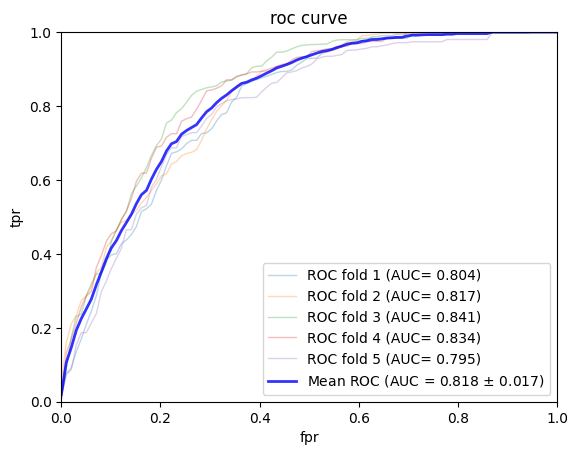

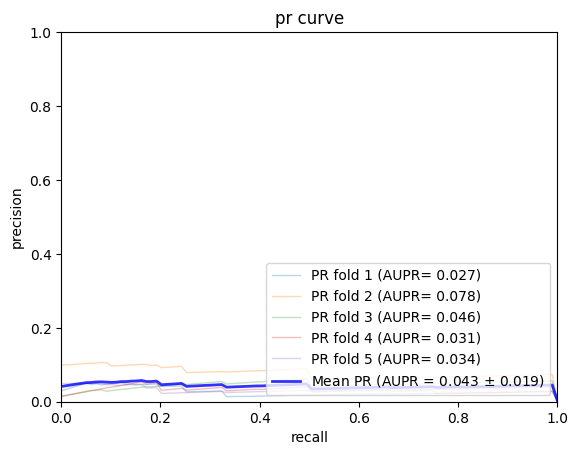

In [8]:
mean_fprs, mean_tprs, mean_recalls, mean_precs= [], [], [], []
_,c_d,fea,tri,test_data=torch.load('./data_circ/dataset/circ_CNN.pth')
# 以疾病为主体
for i in range(5):
    y = torch.load(rf'./res/MLNGCF/label{i}')
    pred = torch.load(rf'./res/MLNGCF/output{i}')
    pred = nn.functional.softmax(pred,dim=1)[:,1]
    test_idx= test_data[i].T
    test_idx= torch.stack([test_idx[:, 1], test_idx[:, 0]], dim= 1)
    mean_fpr, mean_tpr, mean_recall, mean_prec= roc_pr4_folder(test_idx, y, pred, (138, 834))
    mean_fprs.append(torch.tensor(mean_fpr)); mean_tprs.append(torch.tensor(mean_tpr)); mean_recalls.append(torch.tensor(mean_recall)); mean_precs.append(torch.tensor(mean_prec))
mean_fpr_ts, mean_tpr_ts, mean_recall_ts, mean_prec_ts= torch.stack(mean_fprs), torch.stack(mean_tprs), torch.stack(mean_recalls, dim= 0), torch.stack(mean_precs, dim= 0)

roc_pr4cross_val(mean_fpr_ts, mean_tpr_ts, mean_recall_ts, mean_prec_ts, 5)